In [2]:
import sys
import struct
import os
from scapy.all import *
from matplotlib import pyplot as plt
from prettytable import PrettyTable
from utils import *
import numpy as np
import matplotlib.pyplot as plt

ImportError: cannot import name 'animation'

In [ ]:
def get_connections(filename):
    Connections = []
    my_ip = "172.16.105.110"
        
    a = rdpcap(filename)
    sessions = a.sessions()
    
    for session in sessions:
        for id_p,packet in enumerate(sessions[session]):
            if(packet.haslayer(ARP) or packet.haslayer(DNS)):
                continue
                 
            if(packet.haslayer(IP)):
                if(packet.haslayer(TCP)):                
                    flag = False
                    idx = len(Connections)
                    for i,con in enumerate(Connections):
                        if match_TCP(con, packet):
                            flag = True
                            idx = i
                            break
                    if not flag:
                        if packet[IP].src==my_ip:
                            Connections.append({
                                's_ip':packet[IP].src,'d_ip':packet[IP].dst,
                                's_port':packet[TCP].sport,'d_port':packet[TCP].dport,
                                'type':"TCP",
                                'snd_packets':[],
                                'rcv_packets':[]
                            })
                        else:
                            Connections.append({
                                's_ip':packet[IP].dst,'d_ip':packet[IP].src,
                                's_port':packet[TCP].dport,'d_port':packet[TCP].sport,
                                'type':"TCP",
                                'snd_packets':[],
                                'rcv_packets':[]
                            })
                        
                    if packet[IP].src==my_ip:
                        Connections[idx]['snd_packets'].append({
                            "seq":packet[TCP].seq, "len":len(packet[TCP].payload),
                            "flag":packet[TCP].flags, "order": id_p
                        })
                    else:
                        Connections[idx]['rcv_packets'].append({
                            "seq":packet[TCP].seq, "len":len(packet[TCP].payload),
                            "flag":packet[TCP].flags, "order": id_p
                        })
                    pass
            
                elif(packet.haslayer(UDP)):
                    flag = False
                    idx = len(Connections)
                    for i,con in enumerate(Connections):
                        if match_UDP(con, packet):
                            flag = True
                            idx=i
                            break
                    if not flag:
                        if packet[IP].src==my_ip:
                            Connections.append({
                                's_ip':packet[IP].src,'d_ip':packet[IP].dst,
                                's_port':packet[UDP].sport,'d_port':packet[UDP].dport,
                                'type':"UDP",
                                'snd_packets':[],
                                'rcv_packets':[]
                            })
                        else:
                            Connections.append({
                                's_ip':packet[IP].dst,'d_ip':packet[IP].src,
                                's_port':packet[UDP].dport,'d_port':packet[UDP].sport,
                                'type':"UDP",
                                'snd_packets':[],
                                'rcv_packets':[]
                            })
                        
                    if packet[IP].src==my_ip:
                        Connections[idx]['snd_packets'].append({
                            "len":len(packet[UDP].payload),
                                "order": id_p
                        })
                    else:
                        Connections[idx]['rcv_packets'].append({
                            "len":len(packet[UDP].payload),
                            "order": id_p
                        })
                    pass
                else:
                    pass
    #                 break
    
    x = PrettyTable()
    
    x.field_names = ["Connection", "Type", "Num Pkt H2R", "Num Pkt R2H", "Len Data H2R", "Len Data R2H"]
    
    for con in Connections:
        x.add_row([f"{con['s_ip']}:{con['s_port']}->{con['d_ip']}:{con['d_port']}", 
                   con['type'], 
                   len(con['snd_packets']), len(con['rcv_packets']), 
                   sum([pkt['len'] for pkt in con['snd_packets']]), 
                   sum([pkt['len'] for pkt in con['rcv_packets']])])
        
    
    print(x)
    return Connections

In [3]:
norm = get_connections("zoom/zoom_full.pcapng")

+-------------------------------------------+------+-------------+-------------+--------------+--------------+
|                 Connection                | Type | Num Pkt H2R | Num Pkt R2H | Len Data H2R | Len Data R2H |
+-------------------------------------------+------+-------------+-------------+--------------+--------------+
|  172.16.105.110:60450->170.114.10.89:443  | TCP  |      2      |      0      |      31      |      0       |
|  172.16.105.110:60452->170.114.10.89:443  | TCP  |      2      |      0      |      31      |      0       |
|  172.16.105.110:60454->170.114.10.89:443  | TCP  |      2      |      0      |      31      |      0       |
|  172.16.105.110:56786->170.114.10.83:443  | TCP  |      2      |      0      |      31      |      0       |
|  172.16.105.110:52210->170.114.10.71:443  | TCP  |      11     |      9      |     3015     |    34949     |
| 172.16.105.110:45782->198.251.148.137:443 | TCP  |      8      |      6      |     517      |     4871     |
|

In [4]:
lossy = get_connections("zoom/zoom_loss.pcapng")

+--------------------------------------------+------+-------------+-------------+--------------+--------------+
|                 Connection                 | Type | Num Pkt H2R | Num Pkt R2H | Len Data H2R | Len Data R2H |
+--------------------------------------------+------+-------------+-------------+--------------+--------------+
|  172.16.105.110:51752->170.114.10.72:443   | TCP  |      28     |      21     |    11255     |    59523     |
|  172.16.105.110:51754->170.114.10.72:443   | TCP  |      14     |      12     |     3622     |    10030     |
|  172.16.105.110:51494->170.114.10.74:443   | TCP  |      13     |      11     |     2351     |     9710     |
|  172.16.105.110:51756->170.114.10.72:443   | TCP  |      11     |      7      |     2096     |     6263     |
|       255.255.255.255:67->0.0.0.0:68       | UDP  |      0      |      4      |      0       |     1200     |
|  172.16.105.110:51496->170.114.10.74:443   | TCP  |      13     |      12     |     3009     |    3556

In [83]:
norm_pkts = []
retrans = []

In [84]:
prev_seq = 0
prev_len = 0

retransmissions = 0

for info in norm[9]['rcv_packets']:
    if info['seq']==prev_seq and info['len']==prev_len and info['len']!=0:
        retransmissions += 1
    prev_seq = info['seq']
    prev_len = info['len']
    
ratio = retransmissions/len(norm[9]['rcv_packets'])


norm_pkts.append(1-ratio)
retrans.append(ratio)

In [85]:
prev_seq = 0
prev_len = 0

retransmissions = 0

for info in lossy[10]['rcv_packets']:
    if info['seq']==prev_seq and info['len']==prev_len and info['len']!=0:
        retransmissions += 1
    prev_seq = info['seq']
    prev_len = info['len']

ratio = retransmissions/len(lossy[10]['rcv_packets'])
norm_pkts.append(1-ratio)
retrans.append(ratio)

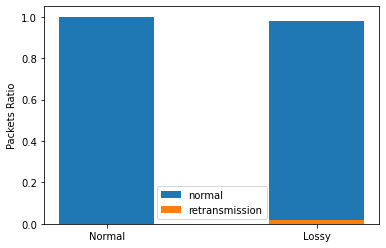

In [88]:
labels = ['Normal', 'Lossy']

width = 0.45  

fig, ax = plt.subplots()

ax.bar(labels, norm_pkts, width, label='normal')
ax.bar(labels, retrans, width, label='retransmission')

ax.set_ylabel('Packets Ratio')
ax.legend()

plt.show()

In [13]:
both = get_connections("zoom/zoom_both.pcapng")
video = get_connections("zoom/zoom_noaudio.pcapng")
audio = get_connections("zoom/zoom_novideo.pcapng")
none = get_connections("zoom/zoom_none.pcapng")

+-------------------------------------------+------+-------------+-------------+--------------+--------------+
|                 Connection                | Type | Num Pkt H2R | Num Pkt R2H | Len Data H2R | Len Data R2H |
+-------------------------------------------+------+-------------+-------------+--------------+--------------+
| 172.16.105.110:48778->198.251.131.69:8801 | UDP  |     555     |      15     |    573070    |     1178     |
| 172.16.105.110:41758->198.251.131.69:8801 | UDP  |      6      |      2      |     418      |     162      |
|  172.16.105.110:42166->198.251.131.69:443 | TCP  |      3      |      4      |      90      |      90      |
| 172.16.105.110:41800->198.251.131.69:8801 | UDP  |      2      |      2      |     162      |     162      |
+-------------------------------------------+------+-------------+-------------+--------------+--------------+
+-------------------------------------------+------+-------------+-------------+--------------+--------------+
|

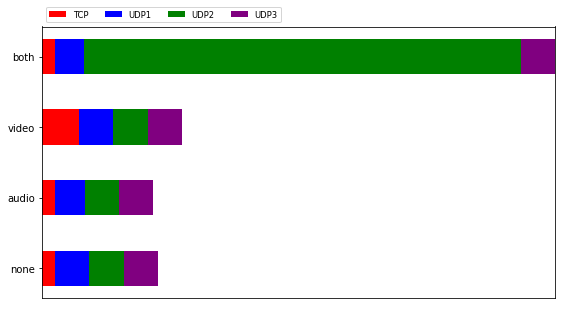

In [16]:
category_names = ['TCP', 'UDP1',
                  'UDP2', 'UDP3']

def count_data(con):
    return sum([pkt['len'] for pkt in con['snd_packets']])/len(con['snd_packets'])


results = {
    'both': [count_data(both[2]), count_data(both[1]), count_data(both[0]), count_data(both[3])],
    'video': [count_data(video[2]), count_data(video[5]), count_data(video[3]), count_data(video[6])],
    'audio': [count_data(audio[0]), count_data(audio[2]), count_data(audio[1]), count_data(audio[3])],
    'none': [count_data(none[0]), count_data(none[2]), count_data(none[1]), count_data(none[3])],
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = ['red', 'blue', 'green', 'purple', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar']

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

#         ax.bar_label(rects, label_type='center', color=color)
        
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.show()

In [96]:
plt.colormaps()

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cividis',
 'cividis_r',
 'cool',
 'cool_r',
 'co